
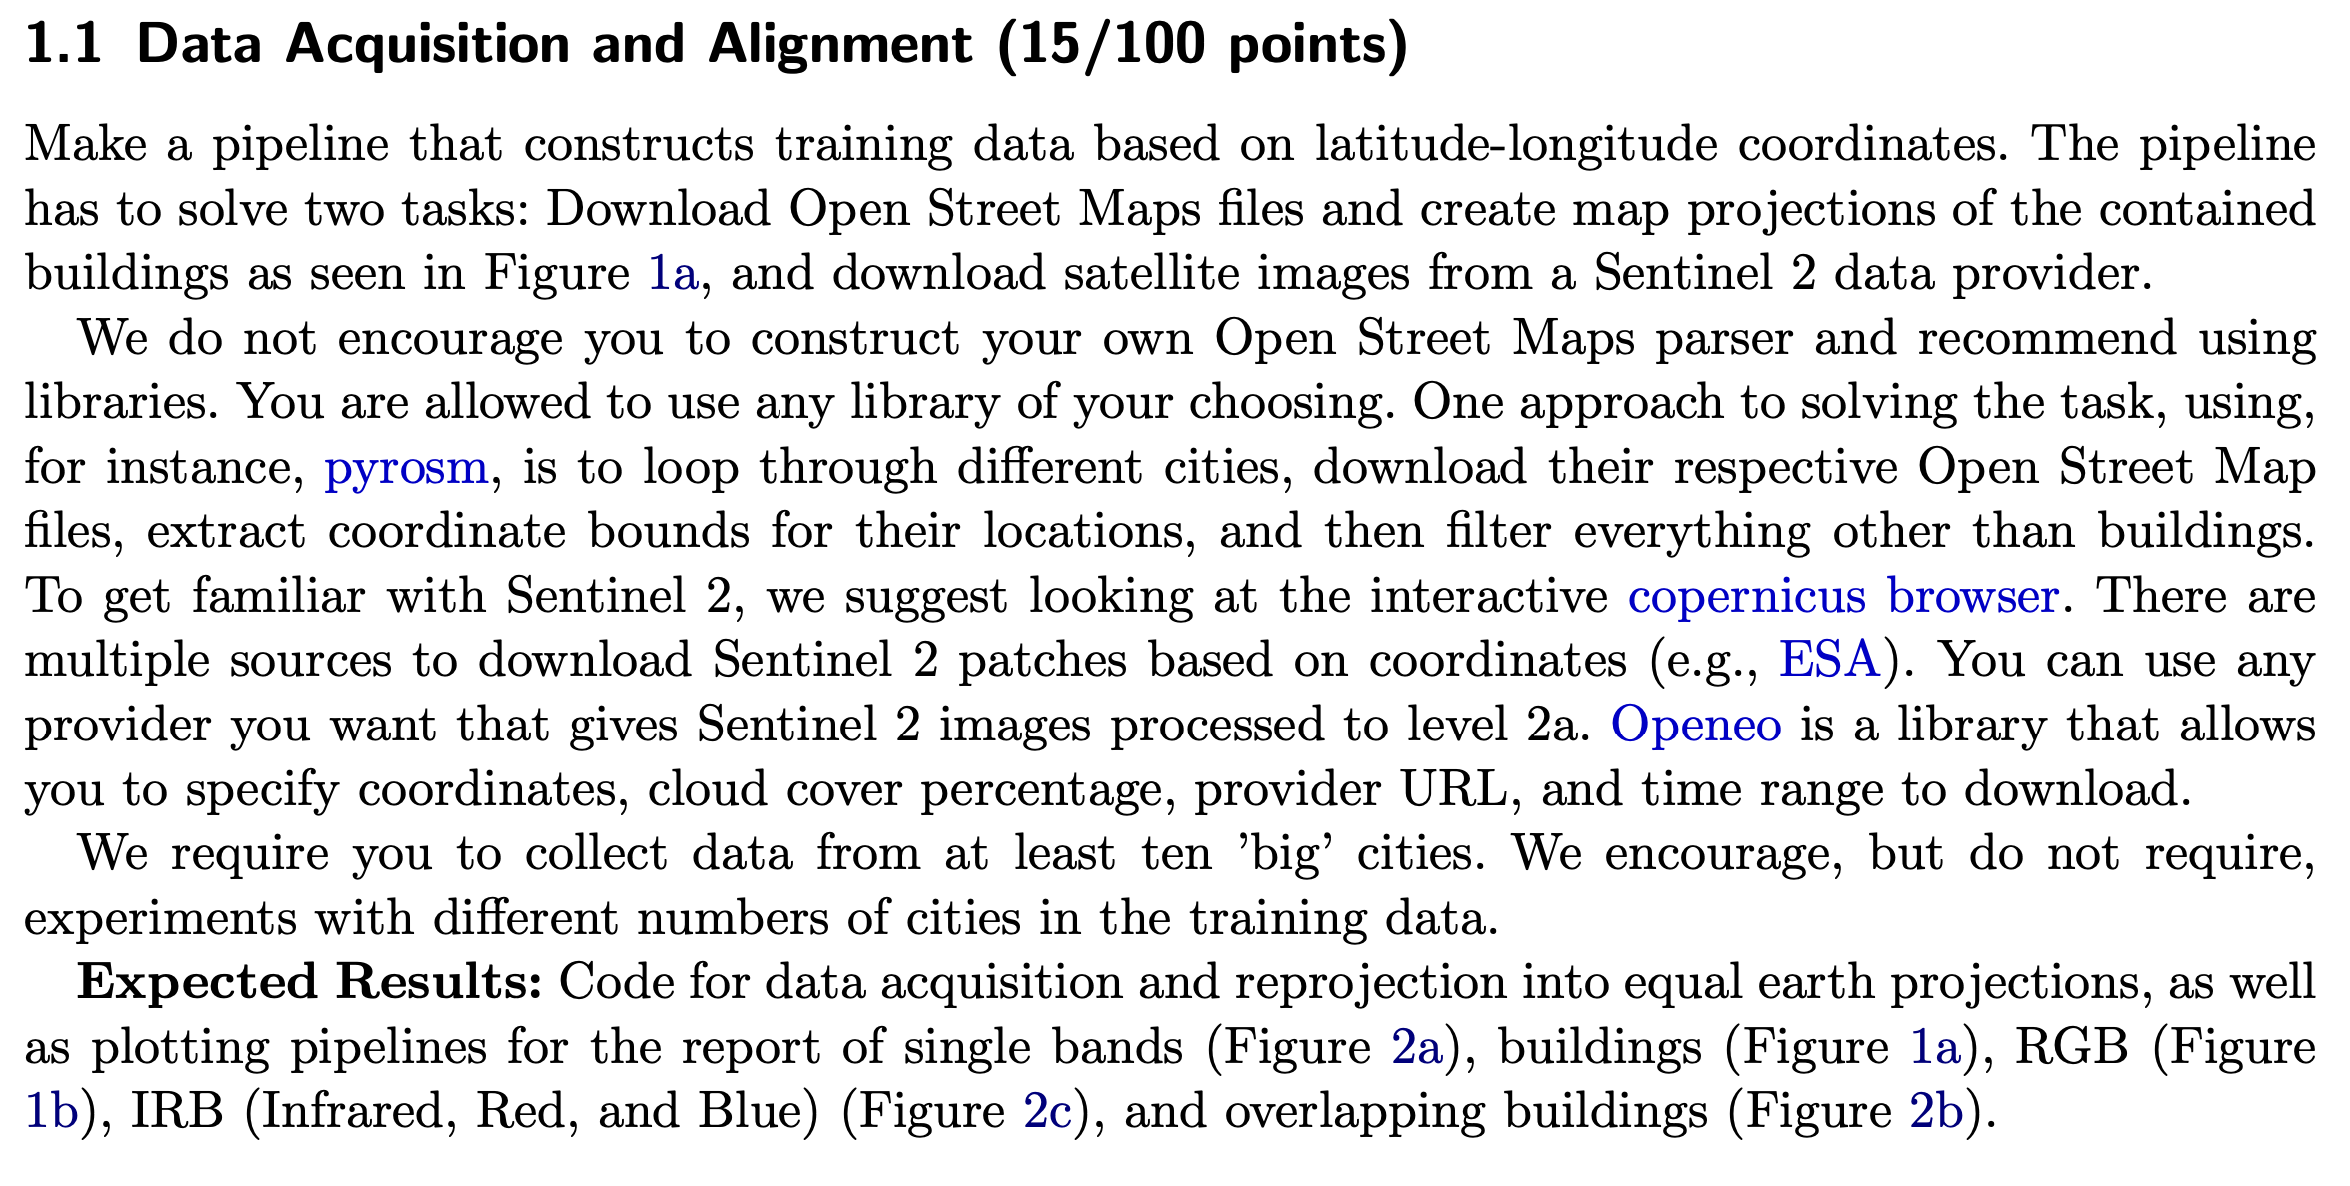

In [21]:
# Data fetching
import pyrosm
import openeo

# Data storing
import os
from pathlib import Path
import xarray
import geopandas as gpd
import numpy as np
import torch

# Data handling
import matplotlib.pyplot as plt
import random
from pyproj import CRS
from PIL import Image
from rasterio.features import rasterize
import albumentations as A
from IPython.display import display
import cv2
import sklearn.feature_extraction.image

# Decorators
from decorators import timeit, measure_memory_usage

In [22]:
# Prepare local directories and file paths
resource_path = Path("ressources/")
resource_path.mkdir(parents=True, exist_ok=True)

osm_data_fp = resource_path / "osm_maps/"
osm_data_geometry_fp = resource_path / "osm_geometries"
osm_data_geometry_fp.mkdir(parents=True, exist_ok=True)
osm_data_fp.mkdir(parents=True, exist_ok=True)

sattelite_images = resource_path / "sattelite_images/"
sattelite_images.mkdir(parents=True, exist_ok=True)

dev_mode_osm_fp = osm_data_fp / "Berlin.osm.pbf"

dev_sat_img_fp = sattelite_images / "composite_sattelite_image.nc"

In [23]:
class Config:
    # Sattelite Related
    sentinel_2_connection_id="SENTINEL2_L2A" # Sentinel data we are dealing with
    single_band = ["B04"]
    rgb_bands = ["B04", "B03", "B02", "SCL"] # Bands we are working with
    irb_bands = ["B08", "B04", "B02", "SCL"]
    all_bands = ["B04","B03", "B02", "B08", "SCL"]
    
    # OSM Related
    MIN_NUMBER_OF_CITIES = 1
    HANDPICKED_CITY_COORDS = [
    [-0.224136,51.425376,0.023057,51.547662],
    [37.502643,55.692206,37.737476,55.814364],
    [28.878773,40.982672,29.075326,41.078498],
    [2.250884,48.815576,2.428039,48.90637],
    [-3.795446,40.361223,-3.605588,40.48302],
    [-2.357444,53.420581,-2.140121,53.540919],
    [2.052497,41.317035,2.228355,41.467914],
    [12.459183,55.644274,12.637024,55.724790],
    [9.902096,53.515476,10.081997,53.605835],
    [20.910186,52.175346,21.097983,52.270619]
    ]
    city_coords = HANDPICKED_CITY_COORDS

    # Feel free to add cities to this list.
    HANDPICKED_CITIES = ["London", "Moscow", "Istanbul", "Paris", "Madrid", "Manchester",
              "Barcelona", "Copenhagen", "Hamburg", "Warsaw"]
    cities = HANDPICKED_CITIES 
    
    # Training Related
    patch_size = 32
    channel_amount = 4 # TODO shouldn't this be 4?
    
    # Coordinate related W, S, E, N (min lng, min lat, max lng, max lat)
    height = 2048 # Default Resolution in the y direction
    width = 2048 # Default Resolution in the x direction
    
    report_city = "berlin"
    report_coordinates = [13.294333, 52.454927, 13.500205, 52.574409] # Berlin test data coordinates

    # epsg references
    # TODO find the right ones
    osm_ref = "EPSG:4326"
        
config = Config()

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# OpenStreetMaps Data:
- Download the city files
- Save relevant information in a format that is quick to access
- Project into proper coordinates
- Rasterize the polygons into pixel related information

In [24]:
class OSMDataLoader:
    
    def __call__(self, city_name: str, bounding_box: list, projected_bbox: list, epsg: CRS,
                 plotResults=False, update=False, height=config.height, width=config.width):
        '''
        Downloads, Fetches and processes OSM data for one city
        Input:
            city_name: Name of city we want to operate on
            bounding_box: bounding box of extracted geometry in angles
            projected_bbox: bounding box of extracted geometry in projected coordinates
            epsg: projected coordinates reference system
            plot: whether to plot the results (for debugging) or not
            update: whether to update the local data or not
        Output:
            Numpy array of OSM buildings data
        '''
        # Make sure everything is downloaded
        fp = self.download_city_data(city_name, bounding_box,update)
        # Get the data
        buildings = self.get_buildings(fp).to_crs(epsg)
        # Rasterizing the data
        rasterized_buildings = self.rasterize_osm(buildings, projected_bbox,height, width)
        # Plotting
        if(plotResults):
            buildings.plot()
            self.plot(rasterized_buildings)
        
        return rasterized_buildings
        
    def download_city_data(self, city_name: str, bounding_box: list, update=False):
        '''
        Downloads the OSM data file for the corrosponding city, saves the file as a gometry folder for
        ease of access, returns the folder path for it.
        Input:
            city_name: Name of the city
            bounding_box: List of WSEN EPSG:4326 Coordinates to extract buildings from and save
            update: whether we update the original .pbf datafile
        Output:
            Filepath for the downloaded file
        '''
        osm_city_local_file_path = osm_data_fp / str(city_name + ".osm.pbf")
        # If the file exists in ressources no need to download it again.
        fp = str(osm_city_local_file_path) if os.path.isfile(osm_city_local_file_path) else False
        # only downloading if the file doesn't already exist in backend
        if not fp:
            fp = pyrosm.get_data(city_name, directory=osm_data_fp)
            
        osm_city_local_geometry_file_path = str(osm_data_geometry_fp) + "/" + str(city_name)
        if update:
            print(f"Deleting the current shapefile for {city_name}")
            # Remove the previous geometry folder
            os.rmdir(osm_city_local_geometry_file_path)
            
        # Save the geometry as a shapefile
        if not os.path.isdir(osm_city_local_geometry_file_path):
            print(f"Saving data for {city_name} as a shapefile...")
            osm = pyrosm.OSM(fp, bounding_box)
            # Get the geometry
            geom = osm.get_buildings().geometry
            # Filter out things that are not buildings in the geometry
            geom = geom.loc[geom.geometry.geometry.type.isin(['MultiPolygon','Polygon'])]
            geom.to_file(osm_city_local_geometry_file_path)
            
        return osm_city_local_geometry_file_path
    
    @timeit
    def get_buildings(self, city_geometry_data_fp: Path):
        '''
        Read the shape file and get the geometry of the buildings as a dataframe
        Input:
            city_geometry_data_fp
        Output:
            GeoDataFrame containing bulding geometry
        '''
        if os.path.isdir(city_geometry_data_fp):
            return gpd.GeoDataFrame.from_file(city_geometry_data_fp)
        else:
            print(f"Folder {city_geometry_data_fp} not found")
    @timeit        
    def rasterize_osm(self, buildings: gpd.GeoDataFrame, coords: list, height, width):
        '''
        Turn the geopandas dataset into a numpy array, 1 where there are buildings, 0 where there is not
        Input:
            buildings: Geometry dataframe to rasterize
            coords: coordinates bounding box that the dataframe uses (Projected in this case)
            width: Width of output image
            height: Height of output image  
        Output:
            Numpy array of shape [height, width,1] indicating buildings per pixel
        '''
        xres = (coords[2] - coords[0]) / width
        yres = (coords[3] - coords[1]) / height
        # Affine transformation
        #| x' |   | a  b  c | | x |
        #| y' | = | d  e  f | | y |
        #| 1  |   | 0  0  1 | | 1 |
        return rasterize(shapes=buildings.geometry,
                         out_shape=(height, width),
                         transform=(xres, 0, coords[0], 0, -yres, coords[3]))[:,:,None]
    
    def plot(self, img: np.ndarray):
        fig = plt.figure(figsize=(16,10))
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.show()
        
osmDataLoader = OSMDataLoader()

# Sentinel 2 Data fetching:
- Download Images in different bands, with cloud coverage and temporal extent specified.
- Pick an appropriate image
- Extract what coordinate system we are working in

In [31]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.
INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')


Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [32]:
class SentinelDataLoader():
    def __init__(self, connection):
        self.connection = connection
    
    def __call__(self, city_name: str, coords: list, bands: list,
                 start_date = "2023-04-01", end_date = "2023-08-30", mask = True, plotResults = False):
        '''
        Downloads, fetches and processes Sentinel 2 sattelite data for one city
        Input:
            city_name: Name of the city we are operating on
            coords: Which coordinates we extract our images from
            bands: Which bands we operate on
            start_data -> end_data: Temporal extent of the potential data we fetch
            mask: Whether to mask clouds or sample the least cloudy day
            plot: Whether to plot results or not
        Output:
            dataArray of the S2 sattelite data
            epsg coordinate reference system of the returned data
            extracted bounded box from the returned data
        '''
        # Make sure we are connected
        if self.connection._oidc_auth_renewer:
            self.connection.authenticate_oidc() 
        # Collect data depending on which approach we prefer
        if mask:
            s2, epsg = self.get_masked_data(city_name, coords, bands)
        else:
            s2, epsg = self.get_least_cloudy_data(city_name, coords ,bands)
        # Extract coordinates
        extracted_coords = self.get_coordinates_from_sattelite_dataArr(s2)
        #Plot
        if plotResults:
            self.plot(s2)
        
        return s2, extracted_coords, epsg
    
    @timeit
    def get_masked_data(self, city_name: str, coords: list, bands: list,
                        start_date = "2023-04-01", end_date = "2023-08-30"):
        '''
        Get a sattelite image of the given city with the given bands.
        If there are clouds, we resample again for a cloudless version for those specific pixels.
        Input:
            city_name: Name of the city we are operating on
            coords: Which coordinates we extract our images from
            bands: Which bands we operate on
            start_data -> end_date: timespan we consider taking images from
        Output:
            Xarray.DataArray of values of each Band according to our bounding box.
            epsg coordinate reference system of the current image
        '''
        city = city_name + "_masked"
        sattelite_img_fp = sattelite_images / str(city + ".nc")

        if not os.path.isfile(sattelite_img_fp):
            # Prepare the Query (Summer/Spring months, Long periods are preferred, low cloud coverage)
            s2_cube = self.connection.load_collection(
                "SENTINEL2_L2A",
                temporal_extent=(start_date, end_date),
                spatial_extent=self.get_spatial_extent(coords),
                bands=config.all_bands,
                max_cloud_cover=30,
            )
            # Mark which band we are using for masking
            scl_band = s2_cube.band("SCL")
            # Mask which pixel values we want replaced
            cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)
            # Resample the resolution (because SCL is 20m res, not 10, it may create artifacts if we dont do this)
            cloud_mask = cloud_mask.resample_cube_spatial(s2_cube)
            # Mask our query and get the mean values
            composite_masked = s2_cube.mask(cloud_mask).mean_time()

            print(f"Saving a masked version of {city_name} locally.")
            composite_masked.download(outputfile=sattelite_img_fp)

        ds = xarray.load_dataset(sattelite_img_fp)
        epsg_code = CRS.from_cf(ds.crs.attrs)
        # Convert xarray DataSet to a (bands, x, y) DataArray
        return ds[bands].to_array(dim="bands"), epsg_code
    
    @timeit
    def get_least_cloudy_data(self, city_name: str, coords: list, bands: list,
                              start_date = "2023-08-01", end_date = "2023-09-30"):
        '''
        Get a sattelite image of the given city with the given bands.
        We iterate through the entire time period and pick the image with the least cloud coverage
        Input:
            city_name: Name of the city we are operating on
            coords: Which coordinates we extract our images from
            bands: Which bands we operate on
            start_data -> end_date: timespan we consider taking images from
        Output:
            Xarray.DataArray of values of each Band according to our bounding box.
            epsg coordinate reference system of the current image
        '''
        city = city_name + "_temporal"
        sattelite_img_fp = sattelite_images / str(city + ".nc")

        if not os.path.isfile(sattelite_img_fp):
            # Prepare the Query (Summer/Spring months, short periods are acceptable , any cloud coverage)
            s2_cube = self.connection.load_collection(
            "SENTINEL2_L2A",
            temporal_extent=(start_date, end_date),
            spatial_extent=self.get_spatial_extent(coords),
            bands=config.all_bands,
            max_cloud_cover=50,
            )

            print(f"Saving a temporal version of {city_name} locally.")
            s2_cube.download(outputfile=sattelite_img_fp)

        ds = xarray.load_dataset(sattelite_img_fp)
        epsg_code = CRS.from_cf(ds.crs.attrs)
        # Convert to Data array
        time_data = ds[bands+["SCL"]].to_array(dim="bands")
        # Variables to save least cloudy day
        min_clouds = float('inf')
        min_index = 0

        for i,inst in enumerate(time_data[3]):
            # Count SCL classes
            indices,counts = np.unique(inst.data,return_counts=True)

            curr = dict(zip(indices, counts))
            # Count cloudy pixels
            cld_small = curr.get(8)
            cld_big = curr.get(9)
            cld_shadow = curr.get(3)
            # Sum up cloudy pixels
            curr_clouds= cld_small if cld_small else 0 + cld_big if cld_big else 0 + cld_shadow if cld_shadow else 0
            # Save minimum cloudyness
            if(curr_clouds<min_clouds):
                min_clouds=curr_clouds
                min_index=i
            # if its not cloudy we immediately take it
            if(min_clouds==0): break
        # Save least cloudy day
        self.least_cloudy_day_data = time_data[:,i,...]

        return time_data[:,i,...],epsg_code
    
    def get_spatial_extent(self, bounding_box: list):
        '''
        Convert bounding box to a dictionary
        '''
        spatial_extent = {
            "west": bounding_box[0], 
            "south": bounding_box[1], 
            "east": bounding_box[2], 
            "north": bounding_box[3],
        }
        return spatial_extent
    
    def get_coordinates_from_sattelite_dataArr(self, dataArr: xarray.DataArray):
        '''
        Takes in a dataArray and returns a bounding box according to its min and max coordinates
        Input:
            dataArr: The dataArray we want to extract from
        Output:
            List as a WSEN coordinates
        '''
        # Assign the coordinates
        coordinates_x, coordinates_y = dataArr.x, dataArr.y
        # Extract the boundary
        east_boundary = coordinates_x.min().values
        west_boundary = coordinates_x.max().values
        south_boundary = coordinates_y.min().values
        north_boundary = coordinates_y.max().values

        return [east_boundary, south_boundary, west_boundary, north_boundary]
    
    def plot(self, data: xarray.DataArray):
        fig, ax = plt.subplots(figsize=(8, 5))
        plt.axis('off')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())  # Removes padding
        plt.gca().yaxis.set_major_locator(plt.NullLocator())  # Removes padding
        
        if len(data.bands) == 1:
            data[0].plot.imshow(vmin=0, vmax=2000, ax=ax, cmap='Greys',  interpolation='bilinear')
        else:
            data[:-1].plot.imshow(vmin=0, vmax=2000, ax=ax)
            
s2DataLoader = SentinelDataLoader(connection)

### Download all the data (this only needs to be run once)

In [33]:
for coord, name in zip(config.city_coords,config.cities):
    # Fetching data
    __ ,projected_coords, epsg = s2DataLoader(name, coord, config.all_bands)
    __ = osmDataLoader.download_city_data(name, coord)

INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.
INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')


Authenticated using refresh token.
get_masked_data Function took 0.1484s


INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.
INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connectio

Authenticated using refresh token.
get_masked_data Function took 0.1428s


INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.


Authenticated using refresh token.
get_masked_data Function took 0.1365s


INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.


Authenticated using refresh token.
get_masked_data Function took 0.1014s


INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')


Authenticated using refresh token.
get_masked_data Function took 0.1611s


INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.
INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connectio

Authenticated using refresh token.
get_masked_data Function took 0.1327s


INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')


Authenticated using refresh token.
get_masked_data Function took 0.1617s


INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.
INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connectio

Authenticated using refresh token.
get_masked_data Function took 0.0758s


INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.


Authenticated using refresh token.
get_masked_data Function took 0.0974s


INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')


Authenticated using refresh token.
get_masked_data Function took 0.0927s


## Visual Example of Pipeline:
- Plotting Sattelite data in different bands
- Plotting OSM data
- Plotting OSM data after rasterization

### Requirements for the report:
Plotting pipelines for the report of single bands (Figure 2a), buildings (Figure 1a), RGB (Figure 1b), IRB (Infrared, Red, and Blue) (Figure 2c), and overlapping buildings (Figure 2b).

In [34]:
# Which City to Display, set to -1 to disable
EXAMPLE_CITY = -1

# Displaying Process
if EXAMPLE_CITY!=-1:
    coord = config.city_coords[EXAMPLE_CITY]
    name = config.cities[EXAMPLE_CITY]
    __, projected_coords, epsg = s2DataLoader(name, coord, config.all_bands, plotResults=True)
    __, __, __ = s2DataLoader(name, coord, config.rgb_bands, plotResults=True)
    __, __, __ = s2DataLoader(name, coord, config.irb_bands, plotResults=True)

In [41]:
def combined_satt_plot(data_list):
        fig, axes = plt.subplots(1, len(data_list), figsize=(48, 10))
        for ax, data in zip(axes, data_list):
            ax.axis('off')
            ax.xaxis.set_major_locator(plt.NullLocator())  # Removes padding
            ax.yaxis.set_major_locator(plt.NullLocator())  # Removes padding
            
            if len(data.bands) == 1:
                data[0].plot.imshow(vmin=0, vmax=2000, ax=ax, cmap='Greys', interpolation='bilinear')
            else:
                data[:-1].plot.imshow(vmin=0, vmax=2000, ax=ax)

        plt.show()

In [ ]:
# Single Band
s_dl = s2DataLoader(config.report_city, config.report_coordinates, config.single_band)
# RGB bands
rgb_dl = s2DataLoader(config.report_city, config.report_coordinates, config.rgb_bands)
# IRB bands
irb_dl = s2DataLoader(config.report_city, config.report_coordinates, config.irb_bands)

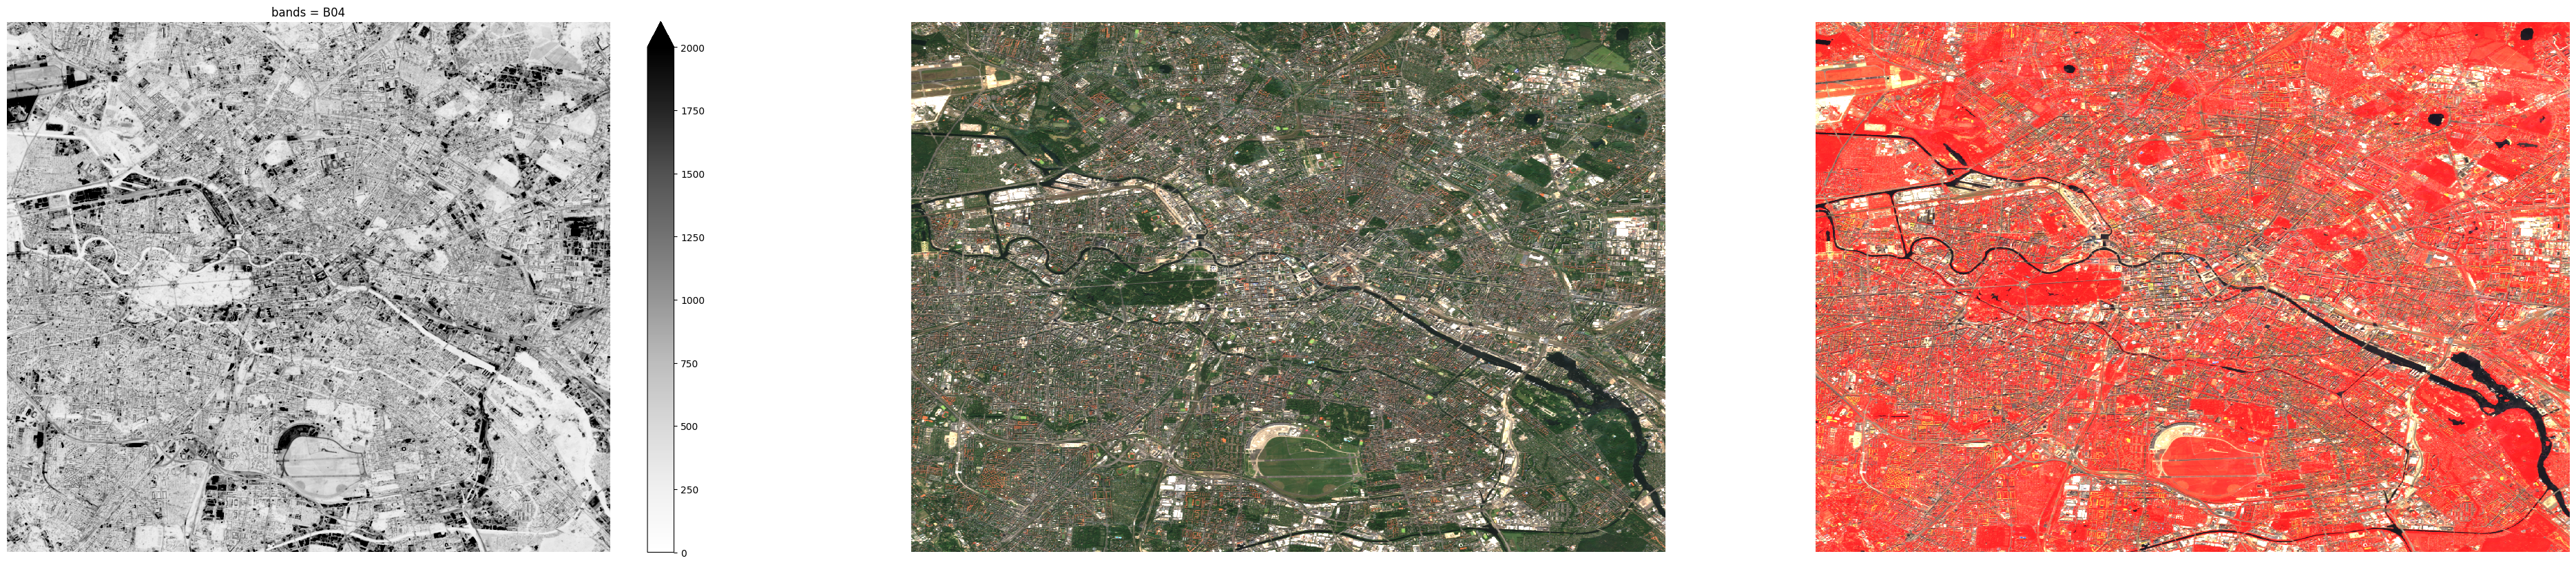

In [42]:
combined_satt_plot([s_dl[0], rgb_dl[0], irb_dl[0]])

## 1.2 Data Preparation
- Sattelite images from Task 1.1 are given in an xarray Dataset of shape [Bands, Height, Width] per image, but also associated with it are variable spatial coordinates.
    - Bands dictating which bands we used
    - X dictating the spatial longitude coordinates of our PixelX
    - Y dictating the spatial latitude coordinates of our PixelY
- Osm data are given as a 2d raster numpy array (pixel_x, pixel_y)

#### Task:
1. Given the pipeline from Task 1.1, prepare the large images for training by slicing out tensors containing smaller training images of equal width and height, for instance, 32, 64, or 128 pixels

2.  include in the pipeline a simple cloud-cover classifier and remove all patches containing clouds.

3. Divide the data into train/validation/test sets of similar data distributions (e.g., label distribution and potentially other properties such as visual similarity or data provenance
- Possible convert into Numpy for ease of use and acceleration

In [ ]:
class PreProcess():
    
    def __call__(self, s2_data: np.ndarray, osm_data: np.ndarray, res_of_patch=config.patch_size, mode="Grid", max_patch=1000,
                 precent=0.02, plotResults=False):
        '''
        Go through the entire pipeline of preprocessing
        1. Convert to numpy
        2. Patch data
        3. Remove clouds
        4. Plot
        Input:
            s2_data: Sattelite image
            osm_data: osm numpy array related to our image
            res_of_patch: resolution of patches we will extract
            mode: Mode of patch extraction
            max_patches: max number of patches to extract (only valid for Random mode)
            precent: tolertable cloud precentage
            plotResults: Plot every step of the process or not
        Output:
            PreProcessed training images and target images for one city
        '''
        # Convert to numpy
        s2_np = self.xarr_to_np(s2_data)
        
        # Slice the combined version and the raw version
        sliced_s2 = self.patch_arr(s2_np, res=res_of_patch, mode=mode, max_patch=max_patch)
        sliced_combined = self.patch_arr(osm_data, res=res_of_patch, mode=mode, max_patch=max_patch)
        
        # Remove cloudy patches
        cloudless_s2, cloudless_osm ,num_of_removed = self.remove_clouds(sliced_s2,sliced_combined, precent)
        
        if plotResults:
            # Plot
            fig = plt.figure(figsize=(15, 15), layout='tight')
            fig.add_subplot(2, 2, 1)
            self.plot(s2_np)
            fig.add_subplot(2, 2, 2)
            self.plot(osm_data)
            fig.add_subplot(2, 2, 3)
            combined = self.combine_sattelite_with_osm_buildings(s2_np, osm_data)
            self.plot(combined)
            
            self.plot_patches(sliced_s2)
            self.plot_patches(sliced_combined)
            
            if num_of_removed>0:
                print(f"Removed {num_of_removed} cloudy patches")
        return (cloudless_s2, cloudless_osm)
    
    @timeit
    def xarr_to_np(self, data: xarray.DataArray):
        '''
        Convert the data array [Bands,x,y] to a numpy array [height,width,bands]
        Use RGB values for normalization + plotting instead of luminance.
        Input:
            data: dataArray containing sattelite images
        Output:
            numpy converted array
        '''
        # reorganizing dimensions
        new_data = np.zeros((data.shape[1],data.shape[2],data.shape[0]))
        for i in range(data.shape[0]):
            new_data[:,:,i] = data[i,:,:]

        # Removal of negative values
        min_v = new_data.min()
        new_data += abs(min_v) if min_v<0 else 0 
        # Removal of outlier values
        # This is done implicitly in dataArray.plot.imshow but not in npArr.imshow
        p_2, p_98 = np.percentile(new_data, (2, 98))
        new_data = np.clip(new_data, p_2, p_98)
        # Normalization according to our new min and max
        new_data = (new_data - p_2) / (p_98 - p_2)
        
        return new_data
    
    @timeit
    def patch_arr(self, data: np.ndarray, res: int, mode: str, max_patch: int):
        '''
        Divide the image into small patches of a given resolution
        Either divide the patches in a grid or extract random patches
        Input:
            data: The data we are extracting the patches from
            res: Resolution of patches
            mode: "Grid" or "Random" to decide the algorithm
            max_patch: number of patches to extract if we choose random selection
        Output:
            Numpy array of shape [Num of Patches, Resolution of patch, Resolution of patch, bands]
        '''
        if mode=="Grid":

            # Generate patches from a regular grid
            min_w = data.shape[0]
            min_h = data.shape[1]
            # Crop edges of patches due to projection errors
            crop_w = int(0.05 * data.shape[0])
            crop_h = int(0.05 * data.shape[1])
            min_w -= crop_w
            min_h -= crop_h
            
            data = data[crop_w:min_w, crop_h:min_h]

            min_w -= crop_w
            min_h -= crop_h
            # If the length dimension does not match a regular subdivision of grids, clip the start of it
            if(min_w%res!=0):
                min_w -= int(min_w - np.floor(min_w/res)*res)
            # If the width dimension does not match a regular subdivision of grids, clip the start of it
            if(min_h%res!=0):
                min_h -= int(min_h - np.floor(min_h/res)*res)
            data = data[:min_w,:min_h]
            return data.reshape((min_w//res,
                                 res,
                                 min_h//res,
                                 res,-1)).transpose(0,2,1,3,4).reshape(-1,res,res,data.shape[2])

        if mode=="Random":
            # Randomly crop out patches from the image (Only supported for np arrays)
            return sklearn.feature_extraction.image.extract_patches_2d(data,
                                                                       (res,res),max_patches=max_patch, random_state=0)
    
    @timeit
    def remove_clouds(self, data: np.ndarray, osm: np.ndarray, precent: float):
        '''
        Iterate over all patches and check if theyre too cloudy and remove them.
        Mostly used if we dont choose the masking operation when extracting images
        Input:
            data: patched data we are operating on
            osm: associated OSM data
            precent: what Precentage of cloud coverage are we willing to tolerate
        Output:
            patched data array without cloudy patches
        '''
        n=data.shape[0]
        for i in range(n):
            if(i==data.shape[0]): break
            if self.detect_cloud_patch(data[i,:,:,-1],precent):
                data = np.delete(data,i,axis=0)
                osm = np.delete(osm,i,axis=0)
        return (data[:,:,:,:-1], osm ,n - data.shape[0])
    
    def detect_cloud_patch(self,img: np.ndarray ,precent: float):
        '''
        Detect cloudyness of one image/patch
        Input:
            img: image we are operating on
            precent: what Precentage of cloud coverage are we willing to tolerate
        Output:
            True if the image is too cloudy, false otherwise
        '''
        p = (np.where((img==1) + (img==2) + (img==8) + (img==9))[0].shape[0] / (img.shape[0]**2))
        return p>precent
    
    def plot(self, data: np.ndarray):
        plt.axis('off')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
        if data.shape[2]>3:
            plt.imshow(data[:,:,:-1])
        elif data.shape[2]==3:
            plt.imshow(data[:,:])
        else:
            plt.imshow(data[:,:,0],cmap='gray')
            plt.axis('off')
            
    def plot_patches(self, p: np.ndarray, start=0 ,row=4, column=16, res=config.patch_size):
        plt.figure(figsize=(column,row))
        plt.axis('off')
        plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
        plt.imshow(p[start:start+row*column,:,:,0:4].reshape(
            row,column,res,res,p.shape[3] if p.shape[3]<5 else 4).transpose(0,2,1,3,4).reshape(
            row*res,column*res,p.shape[3] if p.shape[3]<5 else 4))
        plt.show()
        
    def combine_sattelite_with_osm_buildings(self, s2: np.ndarray, osm: np.ndarray, color=2):
        # For later Use
        osm = osm[:,:,None]
        rev_osm = (-1*osm)
        broad_osm = np.concatenate((osm,rev_osm,rev_osm,np.zeros(osm.shape)), axis=2).squeeze()
        broad_osm[[color,0]] = broad_osm[[0,color]]
        return np.clip((s2[:,:,:4] + broad_osm),0,1)
    
preProcessor = PreProcess()

In [ ]:
def train_val_test_split(X: np.ndarray, y: np.ndarray, indices: list, val=0.1, test=0.2):
    '''
    Split our data into Train, Validation and Test data
    Make sure no data leaks from set to another, Make sure we have equal distributions across every city
    Input:
        X: Images we want to insert into the model
        y: Images we want the model to predict
        indices: Start/end indices of every city
        val: validation precentage
        test: test precentage
    Output:
        Training Images, Training labels, Test images, Test labels, Validation images, Validation labels
    '''
    test_indices = []
    val_indices = []
    ratio = val/(test+val)
    # Generating random indices of validation and test per city
    # we dont want one city to dominate Train/Test/Val subset
    for i in range(1,len(indices)):
        # Total number per distribution per city
        total = indices[i]-indices[i-1]
        val_n = int(val*total)
        test_n = int(test*total)
        total = total - val_n - val_n
        # Sample indices randomly
        total_indices = random.sample(range(indices[i-1],indices[i]),val_n+test_n)
        split = int(ratio*(val_n+test_n))
        # Append the indices
        val_indices = np.concatenate((val_indices,total_indices[:split]))
        test_indices = np.concatenate((test_indices,total_indices[split:]))
    #turn into np array
    val_indices = np.array(val_indices, dtype=int)
    test_indices = np.array(test_indices, dtype=int)
    # Take those indices from our array
    val_X = np.take(X,val_indices,axis=0)
    val_y = np.take(y,val_indices,axis=0)

    test_X = np.take(X,test_indices,axis=0)
    test_y = np.take(y,test_indices,axis=0)
    # Remove them from the original array
    remove = np.concatenate((val_indices,test_indices))
    train_X = np.delete(X,remove,axis=0)
    train_y = np.delete(y,remove,axis=0)

    return (train_X, train_y, val_X, val_y, test_X, test_y)

## Visual Example

In [ ]:
# Which City to Display, set to -1 to disable
EXAMPLE_CITY = 0

# Displaying Process
if EXAMPLE_CITY!=-1:
    # Pick city
    coord = config.city_coords[EXAMPLE_CITY]
    name = config.cities[EXAMPLE_CITY]
    # Get data
    s2, projected_coords, epsg = s2DataLoader(name, coord, config.all_bands)
    osm = osmDataLoader(name, coord, projected_coords, epsg, height=s2.shape[1], width=s2.shape[2])
    # PreProcess data
    preProcessor(s2, osm, plotResults=True)

In [ ]:
# indicates where each cities samples start index wise
sample_indices = []
count = 0

# Iterate over citites
for coord, name in zip(config.city_coords,config.cities):
    print("Processing data for", name)
    # Fetching data
    s2, projected_coords, epsg = s2DataLoader(name, coord, config.all_bands)
    osm = osmDataLoader(name, coord, projected_coords, epsg, height=s2.shape[1], width=s2.shape[2])
    
    # First iteration initilaize X and y 
    if (count==0):
        X,y = preProcessor(s2, osm)
        sample_indices.append(count)
        count+=X.shape[0]
        continue
    
    # Remove clouds from our patches
    cloudless_x,cloudless_y = preProcessor(s2, osm)
    
    # Append them to the final array
    X = np.concatenate((X,cloudless_x),axis=0)
    y = np.concatenate((y,cloudless_y),axis=0)
    
    # Update the indices
    sample_indices.append(count)
    count+=cloudless_x.shape[0]
sample_indices.append(count)

train_X, train_y, val_X, val_y, test_X, test_y = train_val_test_split(X,y,sample_indices)
print(X.shape, y.shape)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

### Expected Results:
Code for data preparation of disjoint train, validation, and test data with
similar distributions of statistics. The report should justify the chosen selection procedure and how it
preserves the similarity of specific properties

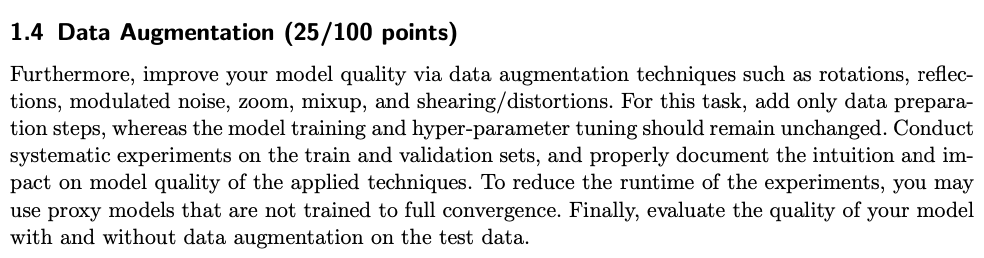

I will now write functions which provide the data augmentation functionality. Doing this before 1.3, because we can probably train with and without the augmented data immediately if we include the data augmentation functions into the pipeline.

Let's start by defining both the geometric and the other transformations

In [ ]:
# cat_min_crop_size = 480
# cat_max_crop_size = 512

# cat_max_shear = 10

# cat_img_size = 512

# osm_img_target_str = 'osm_img'

# cat_geometric_transformations = A.Compose([
#     A.Rotate(limit=45, border_mode=cv2.BORDER_REFLECT, p=1.0),
#     A.HorizontalFlip(p=1),
#     A.VerticalFlip(p=1),
#     A.Affine(shear={'x': (-cat_max_shear, cat_max_shear), 'y': (-cat_max_shear, cat_max_shear)}, p=1), # this adds the black padding. This is okay.
#     A.CenterCrop(height=random.randint(cat_min_crop_size, cat_max_crop_size), width=random.randint(cat_min_crop_size, cat_max_crop_size), always_apply=True),
#     A.PadIfNeeded(min_height=cat_img_size, min_width=cat_img_size, pad_height_divisor=None, pad_width_divisor=None, border_mode=cv2.BORDER_REFLECT, p=1)
# ],
# additional_targets={osm_img_target_str: 'image'})


# # ignoring mixup, I believe it to be unecessarily complex for data augmentations. Instead I am adding RandomBrightnessContrast
# cat_other_transformations = A.Compose([
#     # random noise
#     A.RandomRain(slant_lower = 0, slant_upper=0, brightness_coefficient=1.0, drop_length=2, drop_width=2, drop_color = (0, 0, 0), blur_value=1, rain_type = None,p=1),
#     A.RandomBrightnessContrast(p=0.2),
#     A.GaussNoise(),
# ])

The transformation needs to take as input two images, the sattelite one, and the openstreetmap image.

In [ ]:
# # this is just for testing and debugging, remove later. You can't see anything with the small patches.
# def get_data_augmentation(sattelite_img: np.array, osm_img: np.array, geometric_transformations, other_transformations):
    
#     # sattelite_img = (sattelite_img * 255).astype(np.uint8)
#     # osm_img = (osm_img * 255).astype(np.uint8)
        
    
#     # let's first apply the geometric augmentations
#     transformed_images = geometric_transformations(image = sattelite_img, osm_img = osm_img)
#     geom_sattelite_img, augmented_osm_img = transformed_images["image"], transformed_images[osm_img_target_str]
    
#     augmented_sattelite_img = other_transformations(image=geom_sattelite_img)["image"]

#     return augmented_sattelite_img, augmented_osm_img

# cat_img1 = Image.open("cat.jpg").crop((0, 0, 512, 512))
# cat_img1 = np.asarray(cat_img1)

# cat_img2 = Image.open("cat.jpg").crop((0, 0, 512, 512))
# cat_img2 = np.asarray(cat_img1)

# augmented_sattelite_img, augmented_osm_img = get_data_augmentation(sattelite_img=cat_img1, osm_img = cat_img2, geometric_transformations=cat_geometric_transformations, other_transformations=cat_other_transformations)

# for img in [augmented_sattelite_img, augmented_osm_img]:
#     display(Image.fromarray(img))

Now for the actual sattelite data

In [ ]:
example_satt_image, example_osm_target = train_X[0], train_y[0]
fig = plt.figure(figsize=(10, 10), layout='tight')
fig.add_subplot(1, 2, 1)
preProcessor.plot(example_satt_image)
fig.add_subplot(1, 2, 2)
preProcessor.plot(example_osm_target)

In [ ]:
one_percent_input_size = config.patch_size // 100

max_shear = one_percent_input_size
min_crop_size = config.patch_size - one_percent_input_size * 2
max_crop_size = config.patch_size

osm_img_target_str = 'osm_img'

geometric_transformations = A.Compose([
    A.Rotate(limit=45, border_mode=cv2.BORDER_REFLECT, p=1.0),
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.Affine(shear={'x': (-max_shear, max_shear), 'y': (-max_shear, max_shear)}, p=1), # this adds the black padding. This is okay.
    A.CenterCrop(height=random.randint(min_crop_size, max_crop_size), width=random.randint(min_crop_size, max_crop_size), always_apply=True),
    A.PadIfNeeded(min_height=config.patch_size, min_width=config.patch_size, pad_height_divisor=None, pad_width_divisor=None, border_mode=cv2.BORDER_REFLECT, p=1)
],
additional_targets={osm_img_target_str: 'image'})


# ignoring mixup, I believe it to be unecessarily complex for data augmentations. Instead I am adding RandomBrightnessContrast
other_transformations = A.Compose([
    # random noise
#     A.RandomRain(slant_lower = 0, slant_upper=0, brightness_coefficient=1.0, drop_length=2, drop_width=2, drop_color = (0, 0, 0), blur_value=1, rain_type = None,p=1),
#     A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(),
])

In [ ]:
# this one works on the sattelite and osm data.
def get_data_augmentation(sattelite_images, osm_images, geometric_transformations, other_transformations):
    augmented_satt_images = []
    augmented_osm_images = []

    image_tuples = zip(sattelite_images, osm_images)
    for sattelite_img, osm_img in image_tuples:
        sattelite_img = (sattelite_img * 255).astype(np.uint8)
        osm_img = (osm_img * 255).astype(np.uint8)
            
        
        # let's first apply the geometric augmentations
        transformed_images = geometric_transformations(image = sattelite_img, osm_img = osm_img)
        geom_sattelite_img, augmented_osm_img = transformed_images["image"], transformed_images[osm_img_target_str]
        
        augmented_sattelite_img = other_transformations(image=geom_sattelite_img)["image"]

        augmented_sattelite_img = augmented_sattelite_img / 255
        augmented_osm_img = augmented_osm_img / 255

        augmented_satt_images.append(augmented_sattelite_img)
        augmented_osm_images.append(augmented_osm_img)
        
    return np.array(augmented_satt_images), np.array(augmented_osm_images)

It is now time to augment the entire dataset

In [ ]:
# TODO parallelize
augmented_sattelite_images_1, augmented_osm_images_1 = get_data_augmentation(train_X, train_y, geometric_transformations, other_transformations)
augmented_sattelite_images_2, augmented_osm_images_2 = get_data_augmentation(train_X, train_y, geometric_transformations, other_transformations)
augmented_sattelite_images_3, augmented_osm_images_3 = get_data_augmentation(train_X, train_y, geometric_transformations, other_transformations)
print(augmented_osm_images_1.shape)
print(augmented_sattelite_images_1.shape)

In [ ]:
preProcessor.plot_patches(augmented_sattelite_images_1,2,16)
preProcessor.plot_patches(augmented_osm_images_1,2,16)
preProcessor.plot_patches(augmented_sattelite_images_2,2,16)
preProcessor.plot_patches(augmented_osm_images_2,2,16)
preProcessor.plot_patches(augmented_sattelite_images_3,2,16)
preProcessor.plot_patches(augmented_osm_images_3,2,16)

In [ ]:
augmented_X = np.concatenate((X, augmented_sattelite_images_1, augmented_sattelite_images_2, augmented_sattelite_images_3))
augmented_y = np.concatenate((y, augmented_osm_images_1, augmented_osm_images_2, augmented_osm_images_3))
print(augmented_X.shape)
print(augmented_y.shape)